# 문제 6

[Kaggle 형] train_prob.csv로 문제 failure 예측하는 모델을 만들고, 

test_prob.csv에 대한 failure가 1일 확률 예측하여 다음과 같은 형식의 answer6.csv를 만들어라. 

측정 지표는 AUC(area under of ROC curve)이다. id 는 테스트 케이스의 id 이고, failure에는 failure가 1이 될 확률이다.

id,failure

16115, 0.1

16116, 0.2


**강사: 멀티캠퍼스 강선구(sunku0316.kang@multicampus.com, sun9sun9@gmail.com)**

In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
#pip install --upgrade mlxtend 
import mlxtend
import sys
import xgboost as xgb

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, xgb]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
xgboost 0.80


In [2]:
df_train = pd.read_csv('train_prob.csv', index_col=['id'])
df_test = pd.read_csv('test_prob.csv', index_col=['id'])
# 실제시험 x
s_ans = pd.read_csv('test_prob_ans.csv', index_col=['id'])['failure']

In [4]:
df_train = df_train.assign(
    na_1 = lambda x: x['measurement_3'].isna(),
    na_2 = lambda x: x['measurement_5'].isna(),
)
df_test = df_test.assign(
    na_1 = lambda x: x['measurement_3'].isna(),
    na_2 = lambda x: x['measurement_5'].isna(),
)

In [5]:
# 방법 1: product_code 별로 IterativeImputer를 통한 결측처리를 하고 바로 적용합니다.
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer

imp  = IterativeImputer(
    estimator=LinearRegression(fit_intercept=True), 
    random_state=123
)
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']

df_train[X_imp] = df_train.groupby('product_code')[X_imp].apply(
    lambda x: pd.DataFrame(imp.fit_transform(x), index=x.index, columns=X_imp)
)
df_test[X_imp] = df_test.groupby('product_code')[X_imp].apply(
    lambda x: pd.DataFrame(imp.fit_transform(x), index=x.index, columns=X_imp)
)

X_mean = ['measurement_{}'.format(i) for i in range(10, 17)]
df_train[X_mean] =  df_train.groupby('product_code')[X_mean].transform(
    lambda x: x.fillna(x.mean())
)
df_test[X_mean] =  df_test.groupby('product_code')[X_mean].transform(
    lambda x: x.fillna(x.mean())
)

In [7]:
# 방법 2 : train / test를 통합하여 처리해봅니다.

from sklearn.experimental import enable_iterative_imputer# 구문을 사용하여 실험 단계인 모듈을 활성화하고, 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
# train에 등장하지 않은 수준이 있습니다, test를 포함하여 결측처리 모델을 만듭니다.
s_imp = pd.concat([
        df_train[X_imp + ['product_code']],
        df_test[X_imp + ['product_code']]
], axis=0).groupby('product_code')\
.apply(
    lambda x: IterativeImputer(estimator=LinearRegression(),random_state=123).fit(x[X_imp])
)
# train에 적용합니다.
df_train[X_imp] = df_train[X_imp + ['product_code']]\
            .groupby('product_code')\
            .apply(
                lambda x: pd.DataFrame(s_imp.loc[x.name].transform(x[X_imp]), index=x.index, columns=X_imp)
            )
# test에 적용합니다.
df_test[X_imp] = df_test[X_imp + ['product_code']]\
            .groupby('product_code')\
            .apply(
                lambda x: pd.DataFrame(s_imp.loc[x.name].transform(x[X_imp]), index=x.index, columns=X_imp)
            )
X_mean = ['measurement_{}'.format(i) for i in range(10, 17)]
# 역시 train에 등장하지 않은 수준을 처리하기 위해 합치니다.
df_mean = pd.concat([
            df_train[['product_code'] + X_mean],
            df_test[['product_code'] + X_mean]
        ]).groupby('product_code')[X_mean].agg('mean')

df_train[X_mean] = df_train.groupby('product_code')[X_mean]\
            .apply(lambda x: pd.DataFrame(x.fillna(df_mean.loc[x.name]), index=x.index, columns=x.columns))
df_test[X_mean] = df_test.groupby('product_code')[X_mean]\
            .apply(lambda x: pd.DataFrame(x.fillna(df_mean.loc[x.name]), index=x.index, columns=x.columns))

In [8]:
df_train['loading'] = df_train['loading'].fillna(df_train['loading'].mean())
df_test['loading'] = df_test['loading'].fillna(df_train['loading'].mean())

In [9]:
(
    df_train.isna().sum().sum(), 
    df_test.isna().sum().sum()
)

(0, 0)



- loading의 각 행들에 자연 로그 함수를 적용하여 파생 변수 loading_log를 만든다.

- LR + SFS: \['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17', 'na_1'\] 최적 변수

- LDA: transform / predict

- LR + PCA: n_components=7 + 'loading'

- RF: {'n_estimators': 15, 'max_depth': 7, 'min_samples_split': 512}, ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']



# Kaggle형 풀이 단계

Step 1: 검증 방법을 정하고, 검증 루틴을 만듭니다.

Step 2: Baseline 모델을 만듭니다

Step 3: 모델 선택 루틴을 만듭니다.

Step 4: 모델 개선 작업을 합니다.

## Step1: 검증 방법을 정하고, 검증 루틴을 만듭니다.

Day1에서 했던 Holdout 검증보다 더 안정적인 평가 결과를 얻을 수 있는 교차 검증을 해봅니다.

### GroupKFold에 대해 알아봅니다.

Test의 product_code는 train에서 등장하지 않았습니다.

이를 기반으로 검증 방법을 정해보면, 

product_code에 대해서 검증셋에서는 검증 학습셋에서 등장하지 않는 product_code가 되도록 구성을 하면, 

Test의 현상을 반영하는 검증 루틴을 구성할 수 있습니다.

이에 활용할 수 있는 검증법이 바로 GroupKFold 입니다.

In [10]:
df_train['product_code'].value_counts()

C    5765
E    5343
B    5250
A    5100
Name: product_code, dtype: int64

In [11]:
df_test['product_code'].value_counts()

D    5112
Name: product_code, dtype: int64

In [8]:
from sklearn.model_selection import GroupKFold, cross_validate

gcv = GroupKFold(n_splits=4)
for train_idx, valid_idx in gcv.split(df_train, df_train['failure'], groups=df_train['product_code']):
    print(
        df_train.iloc[train_idx]['product_code'].unique(), 
        df_train.iloc[valid_idx]['product_code'].unique()
    )

['A' 'B' 'E'] ['C']
['A' 'B' 'C'] ['E']
['A' 'C' 'E'] ['B']
['B' 'C' 'E'] ['A']


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cross_validate(
    make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs')),
    df_train[['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17', 'na_1']],
    df_train['failure'],
    cv = gcv,
    groups=df_train['product_code'], 
    scoring='roc_auc',
    return_train_score=True
)

{'fit_time': array([0.033916  , 0.01204276, 0.03124285, 0.03124261]),
 'score_time': array([0.00394773, 0.01562119, 0.        , 0.        ]),
 'test_score': array([0.58823117, 0.58496642, 0.58887652, 0.59535198]),
 'train_score': array([0.59259755, 0.5935028 , 0.59192673, 0.58955959])}

In [16]:
s_hist = list()

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

gcv = GroupKFold(4)
X_all = df_test.columns.tolist()

def eval_model(model_name, clf):
    result = cross_validate(
        clf, df_train[X_all], df_train['failure'], cv=gcv, groups=df_train['product_code'], scoring='roc_auc', 
        return_train_score=True
    )
    s = "Valid: {:.5f}±{:.5f}, Train: {:.5f}±{:.5f}".format(
        np.mean(result['test_score']), np.std(result['test_score']),
        np.mean(result['train_score']), np.std(result['train_score'])
    )
    s_hist.append(pd.Series([model_name, s], index=['name', 'result']))
    display(pd.DataFrame(s_hist).groupby('name').last())
    
def select_model(clf):
    clf.fit(df_train[X_all], df_train['failure'])
    prd = clf.predict_proba(df_test[X_all])[:, 1]
    pd.DataFrame({
        'id': df_test.index,
        'failure': prd
    }, index=None).to_csv('answer6.csv')
    return prd

## Step2: Baseline 모델을 만듭니다.

In [17]:
from sklearn.linear_model import LogisticRegression

# Baseline: LR - SFS - ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17', 'na_1']
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17']),
    ('pt', 'passthrough', ['na_1'])
])
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs'))
eval_model('baseline', clf_lr)

,result
name,
baseline,"Valid: 0.58937±0.00379, Train: 0.59191±0.00146"


## Step3: 모델 선택 루틴을 만듭니다.

In [18]:
prd = select_model(clf_lr)
print("자가 채점: {}".format(roc_auc_score(s_ans, prd)))

자가 채점: 0.5883988309352517


## Step4: 모델 개선 작업을 합니다.

In [30]:
from sklearn.linear_model import LogisticRegression

# Baseline: LR - SFS - ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17', 'na_1']
ct = ColumnTransformer([
    ('std', StandardScaler(), ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17']),
    ('pt', 'passthrough', ['na_1'])
])
clf_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs', C=0.03))
eval_model('baseline', clf_lr)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"


In [31]:
prd = select_model(clf_lr)
print("자가 채점: {}".format(roc_auc_score(s_ans, prd)))

자가 채점: 0.589236285971223


In [32]:
# lr2: LR + feature PCA(n_components = 7)
from sklearn.decomposition import PCA

ct = ColumnTransformer([
    ('std_pca', make_pipeline(StandardScaler(), PCA(n_components=7)), ['measurement_{}'.format(i) for i in range(18)]), # 7개의 주성분으로 변환하는 루틴을 추가합니다.
    ('std', StandardScaler(), ['loading']),
    ('pt', 'passthrough', ['na_1'])
])
clf_lr2 = make_pipeline(ct, LogisticRegression(solver='lbfgs', C=0.03))
eval_model('lr2', clf_lr2)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"


In [39]:
# lr3: Basline + np.log (loading)
from sklearn.preprocessing import FunctionTransformer

ct = ColumnTransformer([
    ('std', StandardScaler(), ['measurement_1', 'measurement_4', 'measurement_14', 'measurement_17']),
    ('log_std', make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler()), ['loading']), # loading에 자연 log 변환을 적용합니다. 
    ('pt', 'passthrough', ['na_1'])
])
clf_lr3 = make_pipeline(ct, LogisticRegression(solver='lbfgs', C=0.05))
eval_model('lr3', clf_lr3)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"
lr3,"Valid: 0.58946±0.00415, Train: 0.59178±0.00147"


In [40]:
# LDA 모델을 사용하여 예측해봅니다.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf_lda = make_pipeline(
    ColumnTransformer([
        ('std', StandardScaler(), ['loading', 'measurement_1', 'measurement_4', 'measurement_14', 'measurement_17']),
        ('pt', 'passthrough', ['na_1'])
    ]), 
    LinearDiscriminantAnalysis()
)
eval_model('lda', clf_lda)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lda,"Valid: 0.58963±0.00396, Train: 0.59196±0.00148"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"
lr3,"Valid: 0.58946±0.00415, Train: 0.59178±0.00147"


In [41]:
prd = select_model(clf_lda)
print("자가 채점: {}".format(roc_auc_score(s_ans, prd)))

자가 채점: 0.5892864208633093


In [42]:
# RF: RandomForestClassifier: {'max_depth': 7, 'min_samples_split': 512, 'n_estimators': 15} 에서

from sklearn.ensemble import RandomForestClassifier
ct = ColumnTransformer([
    ('pt', 'passthrough', ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)])
])
clf_rf = make_pipeline(ct, RandomForestClassifier(
    n_estimators=15, max_depth=7, min_samples_split=512, random_state=123 # TODO 튜닝
))
eval_model('rf', clf_rf)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lda,"Valid: 0.58963±0.00396, Train: 0.59196±0.00148"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"
lr3,"Valid: 0.58946±0.00415, Train: 0.59178±0.00147"
rf,"Valid: 0.57162±0.00305, Train: 0.63545±0.00143"


In [47]:
# RF: RandomForestClassifier: {'max_depth': 7, 'min_samples_split': 512, 'n_estimators': 15} 에서

from sklearn.ensemble import RandomForestClassifier
ct = ColumnTransformer([
    ('pt', 'passthrough', ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)])
])
clf_rf = make_pipeline(ct, RandomForestClassifier(
    n_estimators=100, max_depth=6, min_samples_split=512, random_state=123, max_features=0.75,  # TODO 튜닝
))
eval_model('rf', clf_rf)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lda,"Valid: 0.58963±0.00396, Train: 0.59196±0.00148"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"
lr3,"Valid: 0.58946±0.00415, Train: 0.59178±0.00147"
rf,"Valid: 0.58163±0.00300, Train: 0.63956±0.00229"


In [50]:
# RF: RandomForestClassifier + LinearDiscriminantAnalysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

ct = ColumnTransformer([
    ('std_lda', make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()), ['measurement_{}'.format(i) for i in range(18)]), # 표준화 + LDA 변환
    ('pt', 'passthrough', ['loading', 'na_1', 'na_2'])# + ['measurement_{}'.format(i) for i in range(18)])
])
clf_rf2 = make_pipeline(ct, RandomForestClassifier(
    n_estimators=100, max_depth=6, min_samples_split=512, random_state=123, max_features=0.75
))
eval_model('rf2', clf_rf2)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lda,"Valid: 0.58963±0.00396, Train: 0.59196±0.00148"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"
lr3,"Valid: 0.58946±0.00415, Train: 0.59178±0.00147"
rf,"Valid: 0.58163±0.00300, Train: 0.63956±0.00229"
rf2,"Valid: 0.58567±0.00221, Train: 0.62854±0.00269"


In [59]:
# XGB: XGBoost 

import xgboost as xgb
ct = ColumnTransformer([
    ('pt', 'passthrough', ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(18)])
])
clf_xgb = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.01, colsample_bytree=0.75, subsample=0.75
)
clf_xgb = make_pipeline(ct, clf_xgb)
eval_model('xgb', clf_xgb)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lda,"Valid: 0.58963±0.00396, Train: 0.59196±0.00148"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"
lr3,"Valid: 0.58946±0.00415, Train: 0.59178±0.00147"
rf,"Valid: 0.58163±0.00300, Train: 0.63956±0.00229"
rf2,"Valid: 0.58513±0.00213, Train: 0.62926±0.00249"
xgb,"Valid: 0.58310±0.00282, Train: 0.63206±0.00148"


In [63]:
# Voting을 합니다.
from sklearn.ensemble import VotingClassifier

clf_vt = VotingClassifier([
    ('baseline', clf_lr), # LR + SFS
    ('lr2', clf_lr2), # LR.2: LR +  PCA n_components=7
    #('lr3', clf_lr3), # Basline + np.log (loading)
    ('lda', clf_lda), # LDA
    #('rf', clf_rf), # RF 튜닝
    ('rf2', clf_rf2), # RF + LDA
    #('xgb', clf_xgb), # XGB
], voting='soft')
eval_model('vt', clf_vt)

,result
name,
baseline,"Valid: 0.58957±0.00417, Train: 0.59194±0.00144"
lda,"Valid: 0.58963±0.00396, Train: 0.59196±0.00148"
lr2,"Valid: 0.58876±0.00340, Train: 0.59169±0.00104"
lr3,"Valid: 0.58946±0.00415, Train: 0.59178±0.00147"
rf,"Valid: 0.58163±0.00300, Train: 0.63956±0.00229"
rf2,"Valid: 0.58513±0.00213, Train: 0.62926±0.00249"
vt,"Valid: 0.59011±0.00322, Train: 0.60323±0.00153"
xgb,"Valid: 0.58310±0.00282, Train: 0.63206±0.00148"


In [64]:
prd = select_model(clf_vt)
print("자가 채점: {}".format(roc_auc_score(s_ans, prd)))

자가 채점: 0.5909363758992806


In [67]:
# Voting  을 직접해 봅니다.
model_list = [
    ('baseline', clf_lr), # LR + SFS
    ('lr2', clf_lr2), # LR.2: LR + feature PCA
    ('lda', clf_lda), # LDA
    ('rf2', clf_rf2), # RF + LDA
]

df_vt = pd.concat([
    pd.Series(
        clf.fit(df_train[X_all], df_train['failure']).predict_proba(df_test[X_all])[:, 1],
        index=df_test.index, name=name
    ) for name, clf in model_list
], axis=1)
df_vt

,baseline,lr2,lda,rf2
id,,,,
16115,0.145573,0.157836,0.140965,0.145956
16116,0.178286,0.170452,0.174935,0.182974
16117,0.214873,0.215437,0.214288,0.206596
16118,0.262315,0.264817,0.267748,0.233936
16119,0.214516,0.208379,0.213243,0.224728
...,...,...,...,...
21222,0.176165,0.171221,0.174082,0.164071
21223,0.311826,0.314122,0.318542,0.321941
21224,0.172121,0.165265,0.168644,0.159337


In [69]:
print("자가 채점: {}".format(roc_auc_score(s_ans, df_vt.mean(axis=1))))

자가 채점: 0.5909361510791367


## Stacking

다른 앙상블 기법인 Stacking을 보여드립니다.


참고용입니다. 지금까지 했던 데이터 처리와 머신러닝 기법을 복습해보기 위해 준비했습니다.

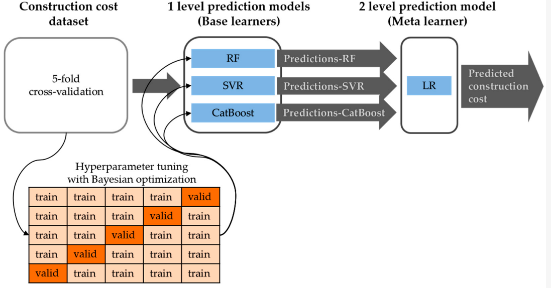

※ 이미지 출처: https://www.mdpi.com/2076-3417/12/19/9729

In [71]:
# 1단계: Cross Validation 예측결과를 모아 메타 모델 학습을 위한 데이터셋을 만듭니다.

# 메타 모델이 접하게되는 데이터는 1차 모델의 예측 결과 인데, 
# 일반화 성능을 높이려면 이 데이터의 분포가 학습하지 않았던 데이터의 분포와 비슷해야 합니다.
# 학습에 사용되지 않았던 겹외셋의 예측 결과 사용하여, 
# 이렇게 데이터의 분포를 실제 예측시의 분포와 최대한 유사하게 해줍니다.
from sklearn.model_selection import cross_val_predict
model_list = [
    ('baseline', clf_lr), # LR + SFS
    ('lr2', clf_lr2), # LR.2: LR + feature PCA
    ('lda', clf_lda), # LDA
    ('rf2', clf_rf2), # RF + LDA
]
# 메타모델을 위한 학습셋을 만듭니다. 
# cross_val_predict는 교차검증의 예측 결과를 입력 변수의 순서에 맞게 제공합니다.
df_cv = pd.concat([
    pd.Series(
        cross_val_predict(
            clf, df_train[X_all], df_train['failure'], groups=df_train['product_code'], cv=gcv, method='predict_proba'
        )[:, 1],
        index=df_train.index, name=model_name
    )
    for model_name, clf in model_list
], axis=1)
df_cv.head()

,baseline,lr2,lda,rf2
id,,,,
0,0.152913,0.163695,0.148474,0.143036
1,0.158226,0.160571,0.154085,0.140442
2,0.166793,0.176534,0.162389,0.174085
3,0.194730,0.198322,0.191887,0.197415
4,0.242718,0.252152,0.249124,0.249651


In [73]:
# 메타 모델을 검증을 해봅니다.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
clf_meta_lr = LogisticRegression(solver='lbfgs')
X_stk = ['baseline', 'lr2', 'lda', 'rf2']
np.mean(
    cross_val_score(
        clf_meta_lr, df_cv[X_stk], df_train['failure'], 
        groups=df_train['product_code'], scoring='roc_auc', cv=gcv
    )
)

0.5897974962485226

In [74]:
# 2단계 메타 모델을 학습 시키고, 예측해 봅니다.

# 테스트 메타 모델 데이터를 만듭니다.
df_stk_test = pd.concat([
    pd.Series(
        clf.fit(df_train[X_all], df_train['failure']).predict_proba(df_test[X_all])[:, 1],
        index=df_test.index, name=model_name
    )
    for model_name, clf in model_list
], axis=1)
display(df_stk_test.head())
# 메타 모델을 학습 시키고, 테스트 메타 모델 데이터로 예측을 합니다.
prd = clf_meta_lr.fit(df_cv[X_stk], df_train['failure']).predict_proba(df_stk_test[X_stk])[:, 1]
print("채점 결과:", roc_auc_score(s_ans, prd))

,baseline,lr2,lda,rf2
id,,,,
16115,0.145573,0.157834,0.140965,0.145956
16116,0.178286,0.170453,0.174935,0.182974
16117,0.214873,0.215439,0.214288,0.206596
16118,0.262315,0.264817,0.267748,0.233936
16119,0.214516,0.208383,0.213243,0.224728


채점 결과: 0.591072392086331
